# 使用机器学习方法对elpv识别数据集

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import os

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
# 复制images和labels数据
!cp -R /content/gdrive/MyDrive/UNSW/9517/LAB/group_project/images ./images/
!cp -R /content/gdrive/MyDrive/UNSW/9517/LAB/group_project/labels.csv ./

## 探索数据预处理

<IPython.core.display.Javascript object>

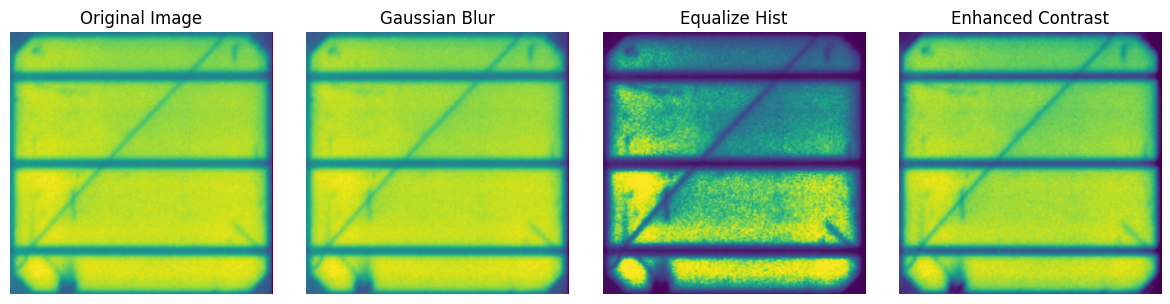

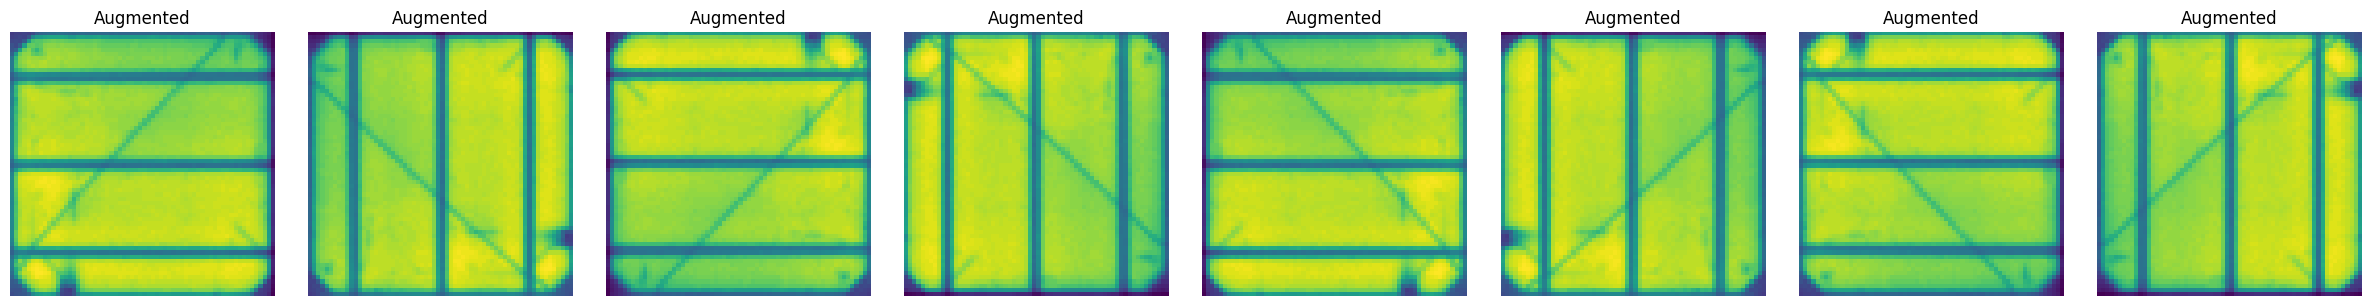

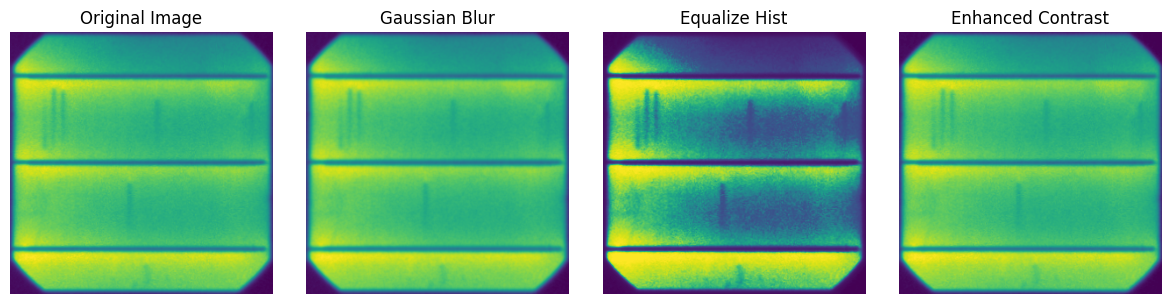

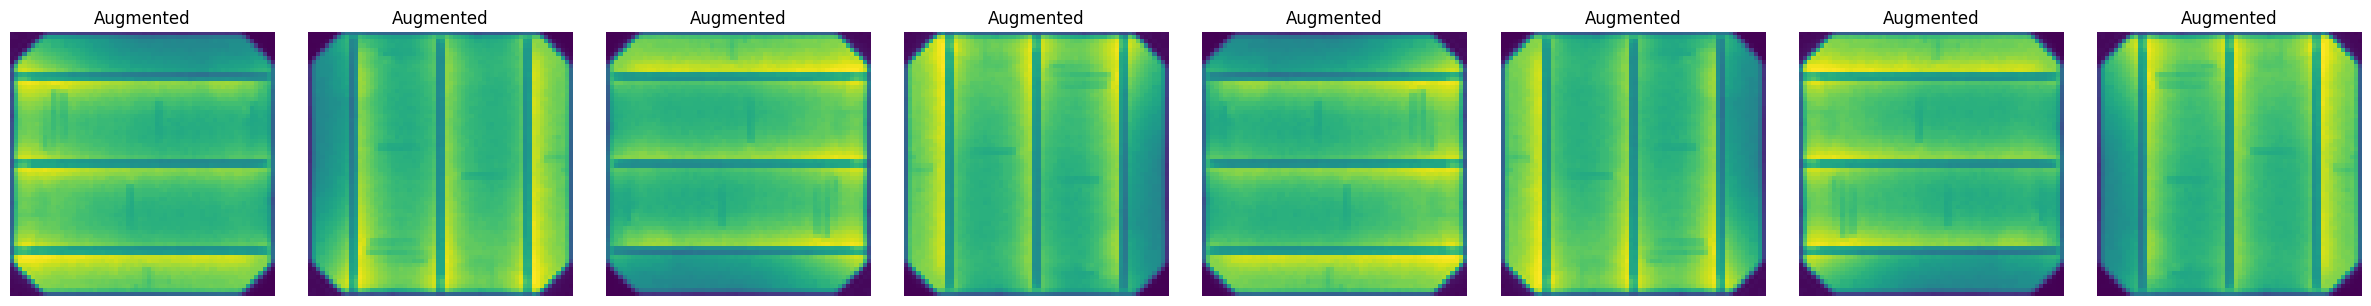

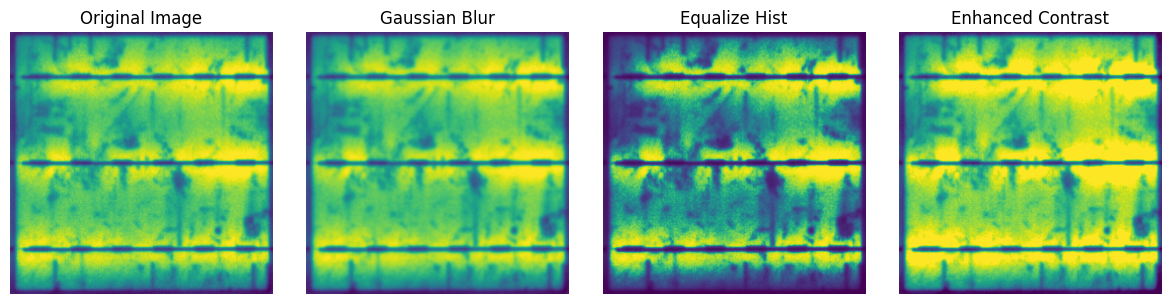

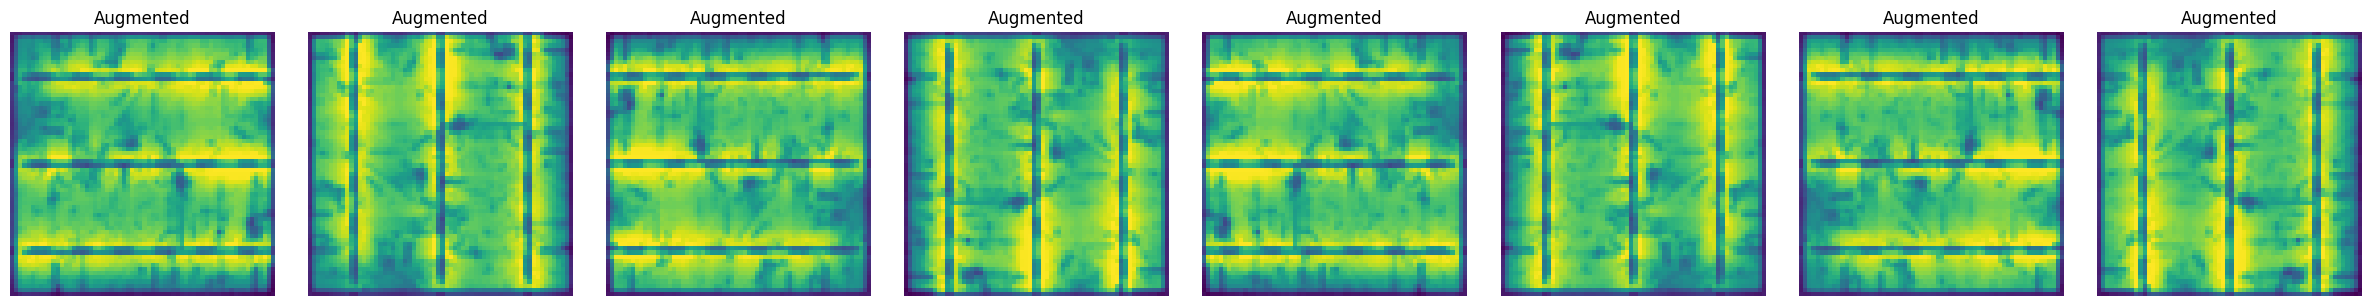

In [39]:
from IPython.display import Javascript

# 移除Colab输出区域的高度限制
def remove_output_scrolling():
    display(Javascript(
        'google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'
    ))

# 调用上面的函数以应用更改
remove_output_scrolling()



# 显示图片网格
def display_image_grid(images, titles, cols, filename):
    rows = (len(images) + cols - 1) // cols  # 计算所需的行数
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    if not isinstance(axes, np.ndarray):  # 如果axes不是数组（即只有一个subplot），将其转换为数组
        axes = np.array([axes])
    for ax, img, title in zip(axes.flat, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{filename}.png")
    plt.show()

# 数据增强函数，产生旋转和翻转的图像
def augment_image(image, new_size):
    # 调整图像大小
    image = image.resize(new_size, Image.LANCZOS)
    # 产生旋转和翻转的图像
    rotations = [0, 90, 180, 270]
    augmented_images = [image.rotate(angle) for angle in rotations]
    augmented_images += [ImageOps.mirror(img) for img in augmented_images]
    return augmented_images


# 主函数：加载数据、应用预处理、展示预处理和增强结果
def preprocess_and_display_images(fname, new_size=(64, 64), augment=False):
    # 读取图片路径
    data = np.genfromtxt(fname, dtype=[('path', 'U19')], delimiter=',', skip_header=1)
    image_fnames = data['path']

    # 处理前两张图片
    for i, fn in enumerate(image_fnames):
        if (i==1 or i==1000 or i==2000):
          img = Image.open(fn)
          processed_images = [img]  # 存储原图和预处理过的图像
          titles = ['Original Image']

          img_blurred = img.filter(ImageFilter.GaussianBlur(radius=1))
          processed_images.append(img_blurred)
          titles.append('Gaussian Blur')

          img_equalized = ImageOps.equalize(img)
          processed_images.append(img_equalized)
          titles.append('Equalize Hist')

          enhancer = ImageEnhance.Contrast(img)
          img_enhanced = enhancer.enhance(1.5)
          processed_images.append(img_enhanced)
          titles.append('Enhanced Contrast')

          # 展示预处理结果
          display_image_grid(processed_images, titles, 4, f"preprocessed_{i}")

          # 如果启用了数据增强，展示增强结果
          if augment:
              augmented_images = augment_image(img, new_size)
              augmented_titles = ['Augmented'] * len(augmented_images)
              display_image_grid(augmented_images, augmented_titles, 8, f"augmented_{i}")

# 调用函数
preprocess_and_display_images('labels.csv', augment=True)


## 数据加载，预处理和数据增强

###  定义数据预处理和数据增强函数

In [40]:
# 数据预处理
def preprocess_image(image, GaussianBlur=False, image_resize=False, new_size=(64, 64), enhance_contrast=False, equalize_hist=False):

    # 调整图像大小
    if image_resize:
      image = image.resize(new_size, Image.LANCZOS)

    # 图像去噪
    if GaussianBlur:
      image = image.filter(ImageFilter.GaussianBlur(radius=1))

    # 直方图均衡化
    if equalize_hist:
        image = ImageOps.equalize(image)

    # 对比度调整
    if enhance_contrast:
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(1.5)  # 对比度增强因子，例如1.5

    return image


# 数据增强
def augment_image(image, new_size):
    # 调整图像大小
    image = image.resize(new_size, Image.LANCZOS)
    # 数据增强：旋转和翻转
    rotations = [0, 90, 180, 270]
    flipped_image = ImageOps.mirror(image)  # 水平翻转
    rotated_images = [image.rotate(angle) for angle in rotations]
    rotated_flipped_images = [flipped_image.rotate(angle) for angle in rotations]
    return rotated_images + rotated_flipped_images



# 数据加载函数，包括预处理和数据增强
def load_dataset(fname='labels.csv',GaussianBlur=False, image_resize=False, new_size=(64, 64), enhance_contrast=False, equalize_hist=False, augment=False):
    data = np.genfromtxt(fname, dtype=[ \
      ('path', np.string_, 19), \
      ('probability', np.float64), \
      ('type', np.string_, 4)], \
      names=['path', 'probability', 'type'])

    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    dir = os.path.dirname(fname)
    images = []
    for fn in image_fnames:
        with Image.open(os.path.join(dir, fn)) as img:
            # 预处理图像
            processed_img = preprocess_image(img,GaussianBlur,image_resize,new_size,enhance_contrast,equalize_hist)
            images.append(np.asarray(processed_img))
            # 如果启用数据增强
            if augment:
                augmented_imgs = augment_image(processed_img, new_size)
                images.extend(np.asarray(img) for img in augmented_imgs)

    # 对所有图像进行归一化
    images = np.array(images).astype('float32') / 255.0

    # 如果进行了数据增强，则相应地重复概率和类型标签
    if augment:
        probs = np.repeat(probs, 9)  # 1原图 + 4旋转 + 4翻转后旋转
        types = np.repeat(types, 9)

    return images, probs, types


# 加载数据
images, probabilities, types = load_dataset(augment=False)

### 加载数据

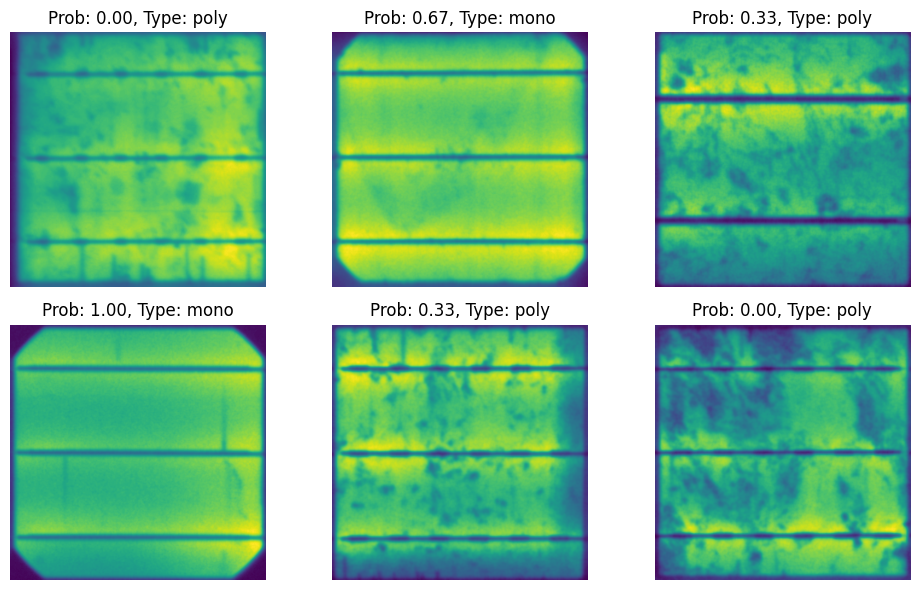

In [41]:
# 使用自带的加载函数来加载数据
images, probabilities, types = load_dataset(GaussianBlur=True, \
                        image_resize=False, new_size=(64, 64), \
                        enhance_contrast=False, \
                        equalize_hist=False,\
                        augment=False)


# 随机展示数据
def display_random_images_with_titles(images, probabilities=None, types=None, n_rows=2, n_cols=3):
    """
    Displays a grid of randomly selected images from a given ndarray of image arrays with titles.
    If probabilities or types are None, no titles will be displayed.

    Parameters:
    - images: An ndarray where each item is an image array.
    - probabilities: An optional ndarray of probabilities associated with each image.
    - types: An optional ndarray of types associated with each image.
    - n_rows: Number of rows in the subplot grid.
    - n_cols: Number of columns in the subplot grid.
    """
    # Number of images to display
    num_images = n_rows * n_cols

    # Ensure the array has the right number of dimensions
    assert images.ndim == 3, "Input images array must be 3-dimensional"

    # Ensure there are enough images to display
    assert images.shape[0] >= num_images, "Not enough images to display. Required: {}, Available: {}".format(num_images, images.shape[0])

    # Randomly select indices for images
    selected_indices = np.random.choice(images.shape[0], size=num_images, replace=False)

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6))

    # Flatten the axes array for easy iteration if necessary
    axes_flat = axes.flat if n_rows * n_cols > 1 else [axes]

    # Check if probabilities and types are provided
    show_titles = probabilities is not None and types is not None

    # Iterate over the selected images and the subplot axes
    for ax, idx in zip(axes_flat, selected_indices):
        # Display the image
        ax.imshow(images[idx])
        if show_titles:
            # If probabilities and types are provided, display them as titles
            ax.set_title(f'Prob: {probabilities[idx]:.2f}, Type: {types[idx]}')
        ax.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

display_random_images_with_titles(images, probabilities, types, n_rows=2, n_cols=3)

### 拆分数据集

In [42]:
# 将图片数据展平成一维向量
images_flatten = np.array([img.flatten() for img in images])

# 标签编码
le_prob = LabelEncoder()
labels_prob = le_prob.fit_transform(probabilities)

# 分离出 'poly' 和 'mono' 的特征和标签
features_poly = images_flatten[types == 'poly']
labels_prob_poly = labels_prob[types == 'poly']

features_mono = images_flatten[types == 'mono']
labels_prob_mono = labels_prob[types == 'mono']

# 使用 train_test_split 分别拆分 'poly' 和 'mono' 数据
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(features_poly, labels_prob_poly, test_size=0.25, random_state=15)

X_train_mono, X_test_mono, y_train_mono, y_test_mono = train_test_split(features_mono, labels_prob_mono, test_size=0.25, random_state=15)

### PCA降维

In [43]:
# PCA降维
pca_poly = PCA(n_components=0.95)
X_train_poly_pca = pca_poly.fit_transform(X_train_poly)
X_test_poly_pca = pca_poly.transform(X_test_poly)

pca_mono = PCA(n_components=0.95)
X_train_mono_pca = pca_mono.fit_transform(X_train_mono)
X_test_mono_pca = pca_mono.transform(X_test_mono)

print(pca_poly.n_components_)
print(pca_mono.n_components_)

89
17


## 6. 数据训练及预测

In [80]:
# poly数据的 SVM 分类器
svm_poly = SVC(kernel='rbf', gamma='scale')
svm_poly.fit(X_train_poly_pca, y_train_poly)

# poly数据的随机森林分类器
rf_poly = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_poly.fit(X_train_poly_pca, y_train_poly)

# mono数据的SVM分类器
svm_mono = SVC(kernel='rbf', gamma='scale')
svm_mono.fit(X_train_mono_pca, y_train_mono)

# mono数据的随机森林分类器
rf_mono = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_mono.fit(X_train_mono_pca, y_train_mono)

# 进行预测
svm_predictions_poly = svm_poly.predict(X_test_poly_pca)
rf_predictions_poly = rf_poly.predict(X_test_poly_pca)
svm_predictions_mono = svm_mono.predict(X_test_mono_pca)
rf_predictions_mono = rf_mono.predict(X_test_mono_pca)



## 7. 展示预测结果

<IPython.core.display.Javascript object>

<Figure size 5000x3000 with 0 Axes>

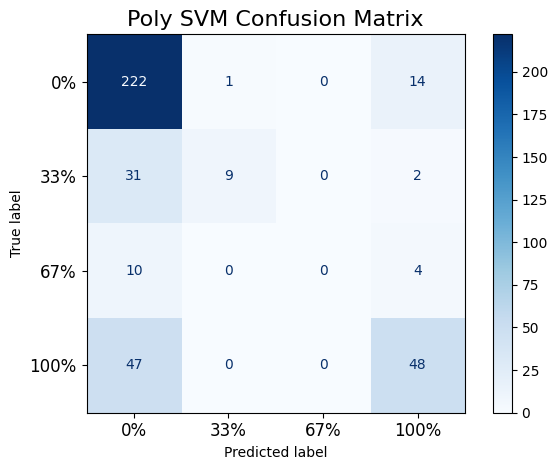

Poly SVM Classification Report:
               precision    recall  f1-score   support

          0%       0.72      0.94      0.81       237
         33%       0.90      0.21      0.35        42
         67%       0.00      0.00      0.00        14
        100%       0.71      0.51      0.59        95

    accuracy                           0.72       388
   macro avg       0.58      0.41      0.44       388
weighted avg       0.71      0.72      0.68       388



<Figure size 5000x3000 with 0 Axes>

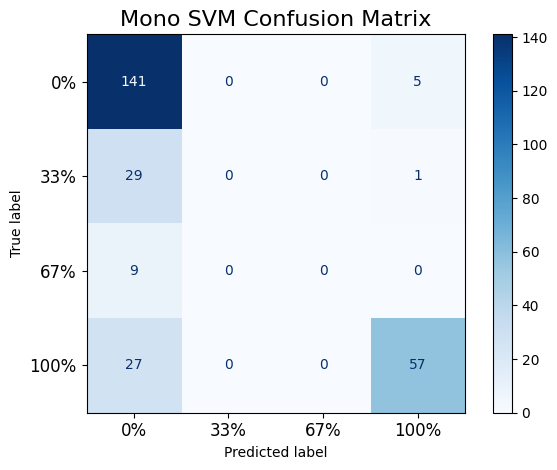

Mono SVM Classification Report:
               precision    recall  f1-score   support

          0%       0.68      0.97      0.80       146
         33%       0.00      0.00      0.00        30
         67%       0.00      0.00      0.00         9
        100%       0.90      0.68      0.78        84

    accuracy                           0.74       269
   macro avg       0.40      0.41      0.39       269
weighted avg       0.65      0.74      0.68       269



<Figure size 5000x3000 with 0 Axes>

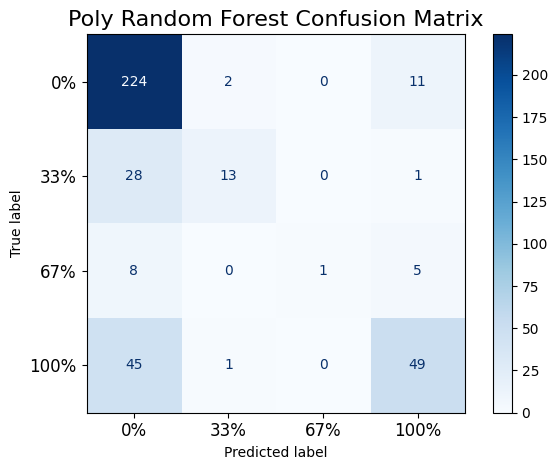

Poly Random Forest Classification Report:
               precision    recall  f1-score   support

          0%       0.73      0.95      0.83       237
         33%       0.81      0.31      0.45        42
         67%       1.00      0.07      0.13        14
        100%       0.74      0.52      0.61        95

    accuracy                           0.74       388
   macro avg       0.82      0.46      0.50       388
weighted avg       0.75      0.74      0.71       388



<Figure size 5000x3000 with 0 Axes>

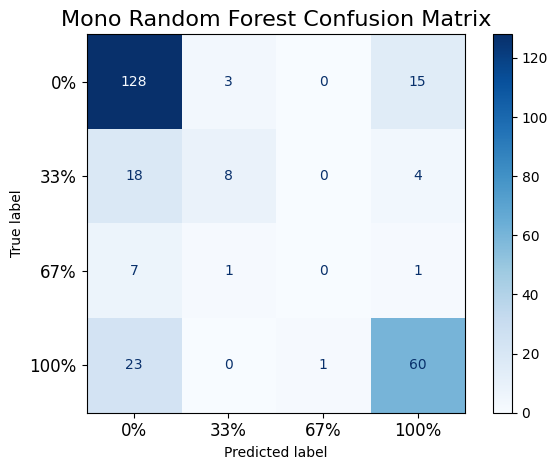

Mono Random Forest Classification Report:
               precision    recall  f1-score   support

          0%       0.73      0.88      0.80       146
         33%       0.67      0.27      0.38        30
         67%       0.00      0.00      0.00         9
        100%       0.75      0.71      0.73        84

    accuracy                           0.73       269
   macro avg       0.54      0.46      0.48       269
weighted avg       0.70      0.73      0.70       269

Poly SVM Accuracy: 0.7190721649484536, F1 Score: 0.6774802193585048
Mono SVM Accuracy: 0.7360594795539034, F1 Score: 0.6769842610920678
Poly Random Forest Accuracy: 0.7396907216494846, F1 Score: 0.7072603577239037
Mono Random Forest Accuracy: 0.7286245353159851, F1 Score: 0.7024777703502173


In [81]:
from IPython.display import Javascript
from sklearn.metrics import f1_score

# 移除Colab输出区域的高度限制
def remove_output_scrolling():
    display(Javascript(
        'google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'
    ))

# 调用上面的函数以应用更改
remove_output_scrolling()



# 绘制混淆矩阵的函数
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', figsize=(50, 30), fontsize=12):
    plt.figure(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title, fontsize=fontsize+4)

    # 增加横纵坐标轴的字体大小
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)


    # 调整边距来确保内容的完整性
    plt.tight_layout()

    plt.show()

# 计算混淆矩阵
svm_cm_poly = confusion_matrix(y_test_poly, svm_predictions_poly)
svm_cm_mono = confusion_matrix(y_test_mono, svm_predictions_mono)

rf_cm_poly = confusion_matrix(y_test_poly, rf_predictions_poly)
rf_cm_mono = confusion_matrix(y_test_mono, rf_predictions_mono)

label_mapping = {
    0: '0%',
    1: '33%',
    2: '67%',
    3: '100%'
}

# 绘制混淆矩阵，打印分类报告
plot_confusion_matrix(svm_cm_poly, classes=list(label_mapping.values()), title='Poly SVM Confusion Matrix')
svm_report_poly = classification_report(y_test_poly, svm_predictions_poly, target_names=list(label_mapping.values()), zero_division=0)
print("Poly SVM Classification Report:\n", svm_report_poly)
plot_confusion_matrix(svm_cm_mono, classes=list(label_mapping.values()), title='Mono SVM Confusion Matrix')
svm_report_mono = classification_report(y_test_mono, svm_predictions_mono, target_names=list(label_mapping.values()), zero_division=0)
print("Mono SVM Classification Report:\n", svm_report_mono)


plot_confusion_matrix(rf_cm_poly, classes=list(label_mapping.values()), title='Poly Random Forest Confusion Matrix')
rf_report_poly = classification_report(y_test_poly, rf_predictions_poly, target_names=list(label_mapping.values()), zero_division=0)
print("Poly Random Forest Classification Report:\n", rf_report_poly)
plot_confusion_matrix(rf_cm_mono, classes=list(label_mapping.values()), title='Mono Random Forest Confusion Matrix')
rf_report_mono = classification_report(y_test_mono, rf_predictions_mono, target_names=list(label_mapping.values()), zero_division=0)
print("Mono Random Forest Classification Report:\n", rf_report_mono)


# 计算poly数据的总体精度
svm_accuracy_poly = accuracy_score(y_test_poly, svm_predictions_poly)
rf_accuracy_poly = accuracy_score(y_test_poly, rf_predictions_poly)
# 计算mono数据的总体精度
svm_accuracy_mono = accuracy_score(y_test_mono, svm_predictions_mono)
rf_accuracy_mono = accuracy_score(y_test_mono, rf_predictions_mono)


# 计算F1分数
f1_score_poly_svm = f1_score(y_test_poly, svm_predictions_poly, average='weighted')
f1_score_mono_svm = f1_score(y_test_mono, svm_predictions_mono, average='weighted')
f1_score_poly_rf = f1_score(y_test_poly, rf_predictions_poly, average='weighted')
f1_score_mono_rf = f1_score(y_test_mono, rf_predictions_mono, average='weighted')

# 打印精度和F1分数
print(f"Poly SVM Accuracy: {svm_accuracy_poly}, F1 Score: {f1_score_poly_svm}")
print(f"Mono SVM Accuracy: {svm_accuracy_mono}, F1 Score: {f1_score_mono_svm}")
print(f"Poly Random Forest Accuracy: {rf_accuracy_poly}, F1 Score: {f1_score_poly_rf}")
print(f"Mono Random Forest Accuracy: {rf_accuracy_mono}, F1 Score: {f1_score_mono_rf}")

## 尝试使用随机森林+SVM的混合模型

<Figure size 5000x3000 with 0 Axes>

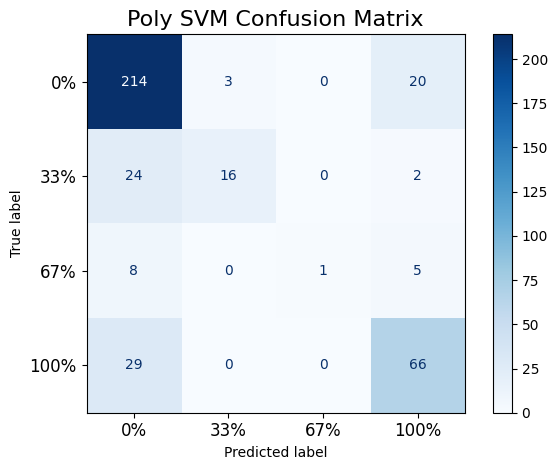

Poly SVM Classification Report:
               precision    recall  f1-score   support

          0%       0.78      0.90      0.84       237
         33%       0.84      0.38      0.52        42
         67%       1.00      0.07      0.13        14
        100%       0.71      0.69      0.70        95

    accuracy                           0.77       388
   macro avg       0.83      0.51      0.55       388
weighted avg       0.78      0.77      0.74       388



<Figure size 5000x3000 with 0 Axes>

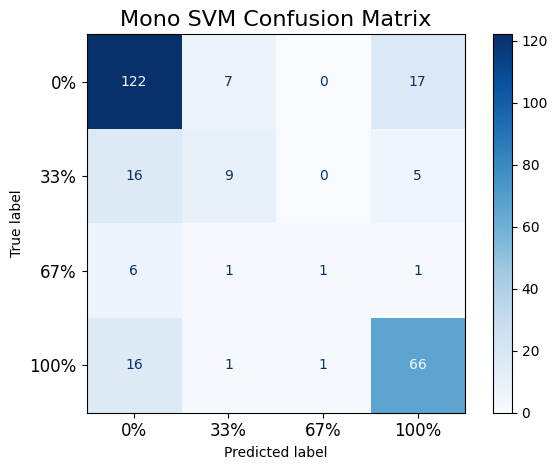

Mono SVM Classification Report:
               precision    recall  f1-score   support

          0%       0.76      0.84      0.80       146
         33%       0.50      0.30      0.37        30
         67%       0.50      0.11      0.18         9
        100%       0.74      0.79      0.76        84

    accuracy                           0.74       269
   macro avg       0.63      0.51      0.53       269
weighted avg       0.72      0.74      0.72       269

Poly SVM Accuracy: 0.7654639175257731, F1 Score: 0.7441205379162037
Mono SVM Accuracy: 0.7360594795539034, F1 Score: 0.718948512412979


In [130]:
# SVM使用随机森林进行特征选择或特征转换，然后将这些特征输入到SVM模型中进行最终的分类，
# 这种方法可以结合两者的优势：随机森林的特征选择能力和SVM的分类效果。

# 训练随机森林模型
rf_poly = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_poly.fit(X_train_poly_pca, y_train_poly)

rf_mono = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_mono.fit(X_train_mono_pca, y_train_mono)

# 使用随机森林模型生成新的特征集
X_train_poly_rf = rf_poly.predict_proba(X_train_poly_pca)
X_test_poly_rf = rf_poly.predict_proba(X_test_poly_pca)

X_train_mono_rf = rf_mono.predict_proba(X_train_mono_pca)
X_test_mono_rf = rf_mono.predict_proba(X_test_mono_pca)

# 训练SVM模型
svm_poly = SVC(kernel='rbf', gamma='scale', probability=True)
svm_poly.fit(X_train_poly_rf, y_train_poly)

svm_mono = SVC(kernel='rbf', gamma='scale', probability=True)
svm_mono.fit(X_train_mono_rf, y_train_mono)

# 进行预测
svm_predictions_poly = svm_poly.predict(X_test_poly_rf)
svm_predictions_mono = svm_mono.predict(X_test_mono_rf)

# 计算混淆矩阵
svm_cm_poly = confusion_matrix(y_test_poly, svm_predictions_poly)
svm_cm_mono = confusion_matrix(y_test_mono, svm_predictions_mono)

# 绘制混淆矩阵，打印分类报告
plot_confusion_matrix(svm_cm_poly, classes=list(label_mapping.values()), title='Poly SVM Confusion Matrix')
svm_report_poly = classification_report(y_test_poly, svm_predictions_poly, target_names=list(label_mapping.values()), zero_division=0)
print("Poly SVM Classification Report:\n", svm_report_poly)

plot_confusion_matrix(svm_cm_mono, classes=list(label_mapping.values()), title='Mono SVM Confusion Matrix')
svm_report_mono = classification_report(y_test_mono, svm_predictions_mono, target_names=list(label_mapping.values()), zero_division=0)
print("Mono SVM Classification Report:\n", svm_report_mono)


# 计算总体精度
svm_accuracy_poly = accuracy_score(y_test_poly, svm_predictions_poly)
svm_accuracy_mono = accuracy_score(y_test_mono, svm_predictions_mono)

f1_score_poly_svm = f1_score(y_test_poly, svm_predictions_poly, average='weighted')
f1_score_mono_svm = f1_score(y_test_mono, svm_predictions_mono, average='weighted')
print(f"Poly SVM Accuracy: {svm_accuracy_poly}, F1 Score: {f1_score_poly_svm}")
print(f"Mono SVM Accuracy: {svm_accuracy_mono}, F1 Score: {f1_score_mono_svm}")